<center>

# Physics 481

## Final - PDE: KdV Soliton


###### Craig Michie, 30001523

</center>
<hr>

Before all, import all packages that may be required

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

<center>
    
## Introduction

The purpose of this final assessment is to test our understandings of techniques used throughout the course. This is done by modifying and analyzing the KdV soliton. The KdV soliton is the mathematical model of waves on shallow water surface. Which is a non linear, dispersive partial differential equation for a function $\phi$ of two real variables, x and t, given by equation 1 and the characteristic shape of the solitary wave solution is given by equation 2
  
  $$ \partial_{t} \phi + \partial_{x}^{3} \phi + 6\,\phi \, \partial_{x} \phi =0 \tag{1}$$
  
 $$ \phi (x,t)= \frac{c}{2} \, \mathrm {sech}^{2}\left[ \frac{\sqrt c}{2}(x-c\,t-a) \right] \tag{2}$$

$$ \int \phi \,\text{d}x \tag{3}$$

  $$ \int \phi ^{2}\,\text{d}x \tag{4}$$
  
  $$ {\int 2\phi ^{3}-\left(\partial _{x}\phi \right)^{2}\,{\text{d}}x} \tag{5}$$

    
 Where the integral in equation 3 defines the conservation of mass, equation 4 defines the conservation of momentum and equation 5 defines the conservation of energy of the KdV Soliton.

    
In this assessment we are asked to complete the following tasks with the KdV soliton, plot Energy versus time, create a function that evaluates the relative error of the numerical solution with the analytical solution (EET) and determine the time it takes to get relative error of 10%, plot contours of the EET function versus ranges of $ \Delta x$ and $ \Delta y$, comment on the parameters of the contour plot and compare to the wave equation, modify the solution so instead of using second degree accuracy, use 4th degree accuracy and repeat the EET analysis using the 4th degree accuracy and discuss how to increase the accuracy of time derivatives and their importance.

    
In this assessment, I will start off with a class and then append the functions required to the class when working through the assessment, just for a more organized and better looking notebook.

In [2]:
class kdv_wave:
    '''
    This class describes the KdV Wave with the functions used throughout 
    this assessment
    '''
    
    def __init__(self, x, t, c, a, save_stride=10):
        '''
        This function initializates all parameters for the soliton.
        Where the paremeters are given as:
            x; Position difference
            t: time difference
            c: speed of wave
            a: wave offset
            save_stride: the factor difference between evaluations
        '''
        
        self.x, self.t = x, t
        self.c, self.a = c, a
        self.dx, self.dt = x[1]-x[0], t[1]-t[0]
        self.dtdx, self.dtdx3= self.dt/self.dx, self.dt/self.dx/self.dx/self.dx
        self.save_stride = save_stride
        
    def soliton(self, x, t, c, a):
        '''
        This function is the solution to the kdv wave, equation (1)
        the result is a single amplitude wave moving along the x axis.
        It returns an array of amplitudes along x
        '''
        
        if a is None: a = np.median(x)  # peak in middle of region
        arg = 0.5*np.sqrt(c) * (x - c*t - a) #right propagating wave
        sech = 1.0 / np.cosh(arg)
        u = 0.5*c * sech**2        
        return u
    
    def second_finite(self, u):
        '''
        This function evaluates the secord order finite difference
        Equation (7) and (8)
        '''
        
        self.du_dx1c = +0.5*np.roll(u,-1) -0.5*np.roll(u,1)# equation (2)
        self.du_dx3c = -0.5*np.roll(u,2) +1.0*np.roll(u,1) -1.0*np.roll(u,-1) +0.5*np.roll(u,-2)
        return u - 6*u*self.du_dx1c*self.dtdx - self.du_dx3c*self.dtdx3
    
    def fourth_finite(self, u):
        '''
        This function evaluates thefourth order finite difference
        Equations (9) and (10)
        '''
        
        self.du_dx1c = (1/12)*np.roll(u,-2)-(2/3)*np.roll(u,-1)+(2/3)*np.roll(u,1)-(1/12)*np.roll(u,2)
        self.du_dx3c = (1/8)*np.roll(u,-3)-1*np.roll(u,-2)+(13/8)*np.roll(u,-1)\
                 -(13/8)*np.roll(u,1)+np.roll(u,2) - (1/8)*np.roll(u,3)
        return u - 6*u*self.du_dx1c*self.dtdx - self.du_dx3c*self.dtdx3
    
    def net_momentum(self, u, t, order4 = False):
        '''
        This function evaluates the momentum of the soliton, changing order4 to True
        will evaluate the energy of the fourth order finite difference, if not stated will 
        solve for momentum of the second order finite difference
        Equation(4)
        '''
        #initial conditions and bounderies
        self.momentum = np.zeros(len(t))
        self.momentum[0] = np.sum(u**2)
        self.stack_m = [u.copy(),]
        
        #loop to evaluate the momentum based off the chosen finite difference
        for indx, tval in enumerate(self.t[1:]):
            if order4:
                u = self.fourth_finite(u=u)
            else:
                u = self.second_finite(u=u)
            
            self.momentum[indx+1] = np.sum(u*u)
            if (indx%self.save_stride == 0): 
                self.stack_m.append(u.copy())

    def net_energy(self, u, t, order4 = False):
        '''
        This function evaluates the energy of the soliton, changing order4 to True
        will evaluate the energy of the fourth order finite difference, if not stated will 
        solve for momentum of the second order finite difference
        Equation (5,6)
        '''
        
        #initial conditions and bounderies
        self.energy = np.zeros(len(t))
        self.energy[0] = np.sum(2*u**3 - (((1/12)*np.roll(u,-2)-(2/3)*np.roll(u,-1)+(2/3)*np.roll(u,1)-\
                                           (1/12)*np.roll(u,2))/self.dx)**2)
        self.stack_e = [u.copy(),]
        
        #loop to evaluate the energy based of the chosen finite difference
        for indx, tval in enumerate(self.t[1:]):
            if order4:
                u = self.fourth_finite(u=u)
            else:
                u = self.second_finite(u=u)

            self.energy[indx+1] = np.sum(2*u**3-(self.du_dx1c/self.dx)**2)
            if (indx%self.save_stride == 0): 
                self.stack_e.append(u.copy())
        
        return self.energy

<center>
    
### Task 1


###### Modify kdv_stepper from class notes to also return the energy. Plot E vs time using the same parameters as the earlier momentum vs time plot and discuss.

    x=np.arange(0.0, 50.0, 0.75)
    t= np.arange(0, 19.0, 0.020)
    u0 = kdv_soliton(x, t = 0.0, c = 1.0, a=np.median(x))



The energy of the soliton wave is given by:
 
 $$ {\int 2\phi ^{3}-\left(\partial _{x}\phi \right)^{2}\,{\text{d}}x} \tag{6} $$

To evaluate the energy, similarly to the midterm we will take an analytical solution and a numerical solution. In this case the analytical solution will be the finite difference over the first step, since the energy should remain constant throughout the wave, the numerical solution will be the evaluation of the third order central difference over a stepper function.


We already figured out the first order central difference equation on the midterm is given by:
    
$$ \frac{\partial u}{\partial x} \approx \frac{u(x+\Delta x)-u(x-\Delta x)}{2\Delta x}\tag{7} $$
   
The central difference third order difference equation is given by:

$$ \frac{\partial^3u}{\partial^3x} \approx \frac{u(x+2\Delta x) - 2u(x+\Delta x)+2u(x-\Delta x)- u(x- 2\Delta x)}{2\Delta x^3}  \tag{8}$$
   

These can now be used for the finite difference for the analytical solution and the numerical solution. As seen in the analytical_energy_solver and Energy functions in the class above. I will first plot the soliton of different c values and the momentum plot, using functions from the class to compare with the plots shown in the notes. 

In [3]:
def soliton_plot_changing_c(x, t, c, a):
    '''
    This function plot the soliton for changing speeds of 0.25, 1 and 4
    '''
    #calling the class
    wave = kdv_wave(x=x, t=t, c=c, a=a, save_stride=99)
    
    #initial conditions for plot
    fig, ax = plt.subplots(1,3,figsize=(15,8),sharey=True)
    x=np.linspace(0,10,1000)
    for ind, c in enumerate([0.25,1,4]):
        phi= wave.soliton(x=x,t=0,c=c, a=None)
        ax[ind].plot(x,phi)
        ax[ind].set_xlabel('x', fontsize=18)
        ax[0].set_ylabel('$\phi$', fontsize=18)
        ax[ind].set_title('soliton wave for c={:4.3f}'.format(c), fontsize=18)
        ax[ind].grid(True)

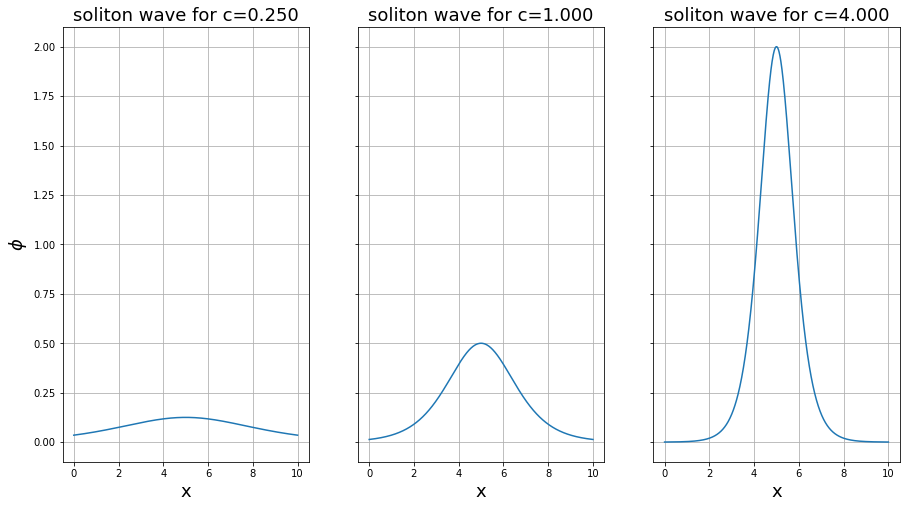

In [4]:
soliton_plot_changing_c(x=np.arange(0.0,50,0.75),t=np.arange(0.0,19.0,0.020),c=1, a=None)

In [5]:
def plot_momentum(x,t,c,save_stride):
    '''
    This function plots the momentum of the soliton wave
    '''
    
    #initial conditions
    a=np.median(x)
    wave= kdv_wave(x=x, t=t, c=c, a=a, save_stride=save_stride)
    u0= wave.soliton(x=x, t=0.0, c=c, a=a)
    wave.net_momentum(u=u0,t=t)
    
    #plot analytical and numerical solutions for momentum 
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    
    #analytical solution
    plt.sca(ax[0])
    plt.xlabel('x', fontsize=18)
    plt.ylabel('amplitude (u)', fontsize=18)
    plt.ylim(0,0.65)
    plt.plot(x,u0,lw=4,ls='-',color='k', label='Analytical')
    
    #numerical solution
    for ind in range(0,len(wave.stack_m)-1,2):
        if np.max(wave.stack_m[ind] > np.max(u0)*1.5):
            break
        plt.plot(wave.x,wave.stack_m[ind], lw=1.5,ls='-',label=str(wave.t[ind*save_stride]))
        plt.grid(True)
        plt.legend(loc=0,title='Time')
        plt.title('Wave Amplitude for Changing Times', fontsize=18)
        
    #plot the relative change in momentum
    plt.sca(ax[1])
    plt.yscale('symlog')
    plt.ylim(-75,75)
    plt.grid(True)
    plt.xlabel('t',fontsize=18)
    plt.ylabel('Relative Change in Momentum [%]', fontsize=18)
    plt.plot(wave.t,100*np.abs(wave.momentum-wave.momentum[0])/wave.momentum[0],'g-',lw=3,label ='Numerical')
    plt.plot(wave.t,wave.t,color='0',ls='--',label='linear')
    plt.plot(wave.t, 1e-1*wave.t*wave.t,'k-.',label='quadratic',alpha=0.4)
    plt.legend(loc=0)
    plt.title('Relative Momentum Change (%)', fontsize=18)
        
        
    

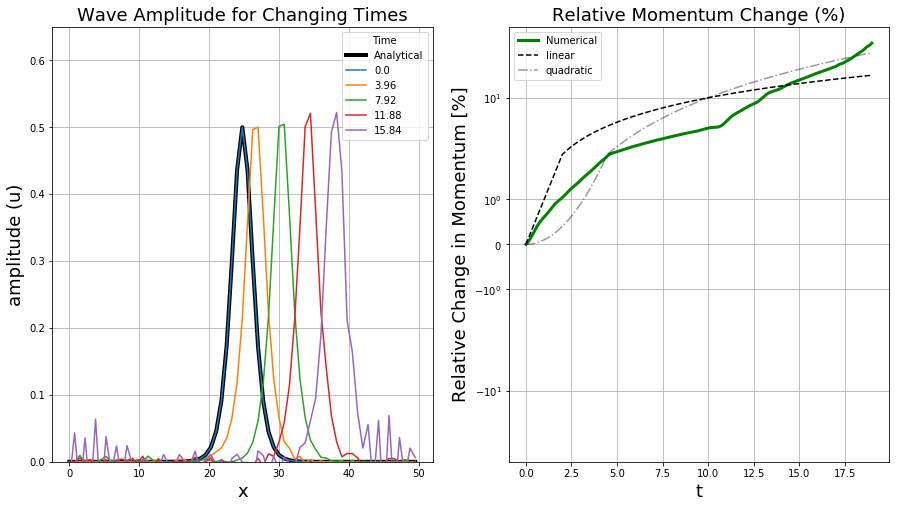

In [6]:
plot_momentum(x=np.arange(0,50,0.75),t=np.arange(0,19,0.020),c=1,save_stride=99)

Comparing these plots to the plots from the posted slides, there seems to be no noticable differences, this ensures to me that my analysis of the numerical solution and code are correct so it is safe to move onward to plotting energy amd the relative energy.

In [7]:
def plot_energy(x,t,c,save_stride):
    '''
    This function plots the energy of the soliton wave
    '''
    
    #initial conditions
    a=np.median(x)
    wave= kdv_wave(x=x,t=t,c=c,a=a,save_stride=save_stride)
    u0=wave.soliton(x,t=0,c=c,a=a)
    wave.net_energy(u=u0,t=t)
    
    #plotting energy
    fig,ax = plt.subplots(1,2,figsize=(15,8))
    plt.sca(ax[0])
    plt.xlabel('x',fontsize=18)
    plt.ylabel('amplitude (u)', fontsize=18)
    plt.ylim(0,0.65)
    
    #analytical solution
    plt.plot(x,u0,lw=4,ls='-',color='k',label='Analytical')
    
    #Numerical solution
    for ind in range(0,len(wave.stack_e)-1,2):
        if np.max(wave.stack_e[ind]) > np.max(u0)*1.5:
            break
        plt.plot(wave.x,wave.stack_e[ind],label=str(wave.t[ind*save_stride]))
    plt.grid(True)
    plt.legend(loc=0, title='Time')
    plt.title('Wave Amplitude for Changing Times', fontsize=18)
    
    #Energy change
    plt.sca(ax[1])
    plt.yscale('symlog')
    plt.ylim(-75,75)
    plt.grid(True)
    plt.xlabel('t',fontsize=18)
    plt.ylabel('Relative Error in Energy [%]', fontsize=18)
    plt.title('Relative Error in Energy Change (%)', fontsize=18)
    plt.plot(wave.t,100*np.abs((wave.energy-wave.energy[0])/wave.energy[0]), 'g-',lw=3,label = 'Numerical')
    plt.plot(wave.t,wave.t,color='0',ls='--',label='linear')
    plt.plot(wave.t, 1e-1*wave.t*wave.t,'k-.',label='quadratic',alpha=0.4)
    plt.legend(loc=0)
    
    

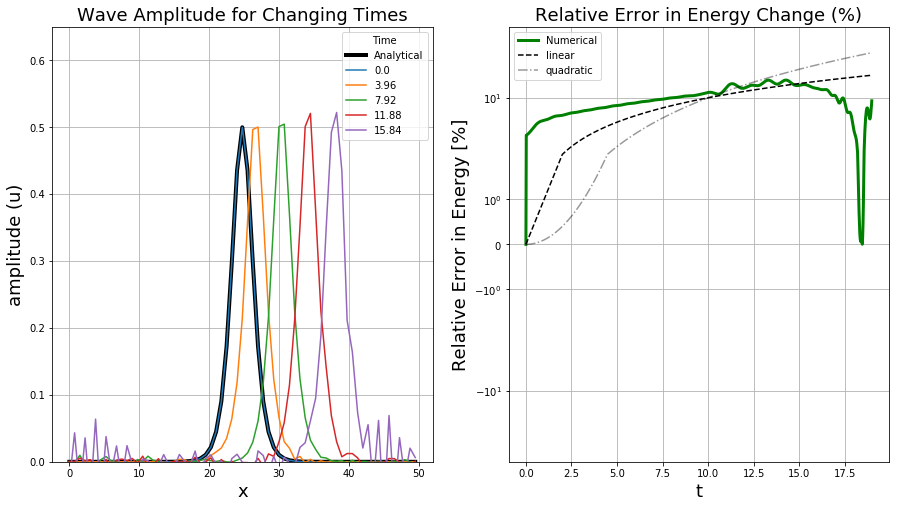

In [8]:
plot_energy(x=np.arange(0.0,50.0,0.75),t=np.arange(0,19,0.020),c=1.0,save_stride=99)

Looking at the relative energy error, it can be observed that the linear plot, quadratic plot and the numerical solution all meet up and are similar for the times 7.5 to 15 before the numerical solution appears to blow up. It also appears the reletive error acts as a inear plot until it blows up at around 16 seconds. However it appears that the numerical solution jumps in this time frame increasing the relative error, due to this it will be interesting to see the plot of the energy error time function and see when the error in energy exceeds 10%.

<center>
    
### Task 2


###### Write a function "energy_error_time" (EET) that returns the time at which the absolute relative error in energy exceeds 10%

</center>

In [9]:
def EET (x, t, time, c, save_stride, plot= False):
    '''
    THis function plots the numerical and analytical error
    and will indicste the moment the relative error exceeds 10%
    '''
    
    #Initial conditions 
    a=np.median(x)
    wave=kdv_wave(x=x,t=t,c=c,a=a,save_stride=save_stride)
    u0=wave.soliton(x,t=time,c=c,a=a)
    wave.net_energy(u=u0,t=t)
    
    #moment error exceeds 10%
    for rel_error in range(len(t)):
        if 100*np.abs(wave.energy[rel_error]-wave.energy[0])/wave.energy[0] > 10:
            break
    #plot
    if plot:
        plt.figure(figsize=(15,8))
        plt.xlim(0,max(t))
        plt.xlabel('time (s)', fontsize=18)
        plt.ylabel('Relative Error in Energy (%)', fontsize=18)
        plt.plot(wave.t,100*np.abs(wave.energy-wave.energy[0])/wave.energy[0], label = 'Numerical')
        plt.plot([0,max(t)],[0,0],label='analytical',ls='--')
        plt.plot(wave.t[rel_error],100*np.abs(wave.energy[rel_error]-wave.energy[0])/wave.energy[0],'ro',label = 'Error > 10%')
        plt.grid(True)
        plt.legend()
        plt.title('Plot of Numerical and Analytical Energy that Shows when Relative Error exceeds 10%', fontsize= 18)
        plt.show()
    
    return wave.t[rel_error]

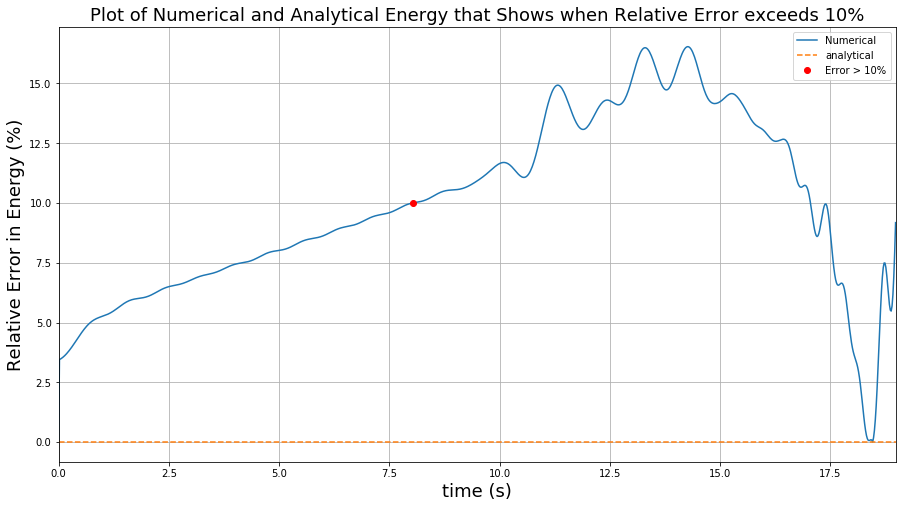

The Moment that relative error exceeds 10% is 8.040000000000001 seconds


In [10]:
relative_error = EET(x=np.arange(0.0,50,0.75),t=np.arange(0,19,0.020),time=0,c=1,save_stride=99,plot=True)

print('The Moment that relative error exceeds 10% is',relative_error,'seconds')

From this plot we can see that the error in the plot increases linearly up to 11 seconds and then the numerical solution blows up, which is idicated due to the wild increases and decreases in accuracy, For the second order finite difference, I would say that it is accurate until the relative error exceeds 10%, so in practice the second order difference works effectively for 8 seconds.

<center>
    
### Task 3


###### Plot contours of EET versus a range of $\Delta X$ and $\Delta T$ values.  Discuss which parameters should be used to integrate for long periods with the (possibly contradictory) goals of maximizing accuracy and minimizing computational time.  How does this compare to the wave equation?
</center>

In [11]:
def plot_contour(dx_val, dt_val):
    '''
    This function plots the contour to determine the optimum resolution for x ant t
    '''
    
    #initial conditions
    X,Y = dx_val, dt_val
    Z = np.zeros((len(X),len(Y)))
    
    #Set uup boundries and evaluate relative energy
    for ind_x, dx in enumerate(X):
        for ind_t,dt in enumerate(Y):
            x=np.arange(0,50,dx)
            t=np.arange(0,19,dt)
            
            wave = kdv_wave(x=x,t=t,c=1,a=None)
            u0 = wave.soliton(x=x,t=0,c=1,a=None)
            wave.net_energy(u=u0,t=np.arange(0,19,dt))
            
            for rel_error in range(len(t)):
                if(np.abs(wave.energy[rel_error]-wave.energy[0]))/wave.energy[0] > 0.1:
                    Z[ind_x,ind_t] = wave.t[rel_error]
                    break
    plt.figure(figsize=(15,8))
    plt.ylabel('Resolution of Time (dt)', fontsize=18)
    plt.xlabel('Resolution of Positions (dx)', fontsize=18)
    plt.title('Time when Relative Error of dt and dx Exceeds 10%', fontsize = 18)
    plt.contourf(X,Y,np.transpose(Z),99,cmap='plasma')
    plt.grid(linestyle = '--')
    cbar=plt.colorbar()
    cbar.set_label('Time (s)', fontsize=18)
    return np.max(Z), np.unravel_index(np.argmax(Z, axis=None), Z.shape)

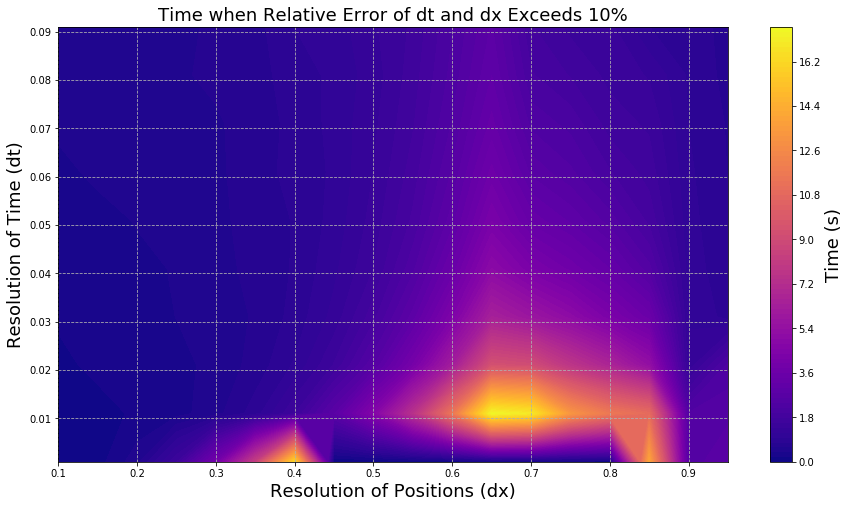

In [12]:
dx_val = np.arange(0.1,1.0,0.05)
dt_val = np.arange(0.001,0.1,0.01)
time, index = plot_contour(dx_val, dt_val)
dx = dx_val[index[0]]
dt = dt_val[index[1]]




In [13]:
print('when the positional resolution is ' +str(dx)+ ' and the time resolution is '+str(dt)+ ' the will be good for ' +str(time)+' seconds.')


when the positional resolution is 0.6500000000000001 and the time resolution is 0.011 the will be good for 17.435 seconds.


I set the range on the contour plot to 0.1,1.0 with incriments of 0.05 for dx and 0.001, 0.1 with increments of 0.01 for dt, since the spacing to see how the change in the resolution affects the relative error. I also decided to print the lowest spacing for x and t and the time that resolution is accurate to since this should be the most accurate solution as it has the most spacing. From this plot, the brightest spots indicate the values of dt and dx that would return the longest time run with accuracy going below 10%.

From the plot we see that this occurs when dx = 0.65 and dt is 0.011 which runs for 17.435, I will now plot the EET for these values to see how that compares to the original EET for the given parameters of task 1

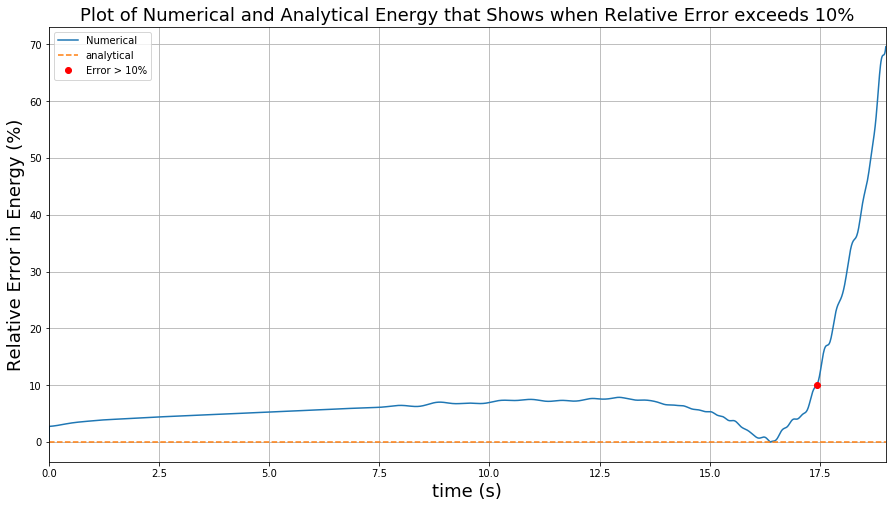

The Moment that relative error exceeds 10% is 17.435 seconds
22.5 ns ± 0.217 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
25.4 ns ± 0.327 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [14]:
relative_error = EET(x=np.arange(0.0,50,0.75),t=np.arange(0,19,0.020),time=0,c=1,save_stride=99,plot=False)

updated_relative_error = EET(x=np.arange(0.0,50,0.65),t=np.arange(0,19,0.011),time=0,c=1,save_stride=99,plot=True)

print('The Moment that relative error exceeds 10% is',updated_relative_error,'seconds')
%timeit relative_error
%timeit updated_relative_error

Comparing this plot to the plot of the EET from earlier we see that the accuracy of the plot lasts for twice as long and blows up later on. From these times we also see this increase in accuracy has little to no effect on the computational timing so using the increased accuracy has no negatives

<center>
    
### Task 4


###### Modify kdv_stepper so that spatial derivatives are evaluated with 4th degree accuracy instead of 2nd degree.  Note: https://en.wikipedia.org/wiki/Finite_difference_coefficient may be useful.
</center>

From the wikipedia page it was determined that the fourth order central differential equations are given as:

$$\frac{\partial u}{\partial x} \approx \frac{1}{12}u(x-2\Delta x) - \frac{2}{3}u(x-\Delta x) + \frac{2}{3}u(x+\Delta x) - \frac{1}{12}u(x+2\Delta x) \tag{9}$$

$$\frac{\partial^3u}{\partial^3x} \approx \frac{1}{8}u(x-3\Delta x) -u(x-2\Delta x)+ \frac{13}{8} u(x-\Delta x) -\frac{13}{8} u(x+\Delta x) + u(x+2\Delta x) -\frac{1}{8}u(x+3\Delta x) \tag{10} $$


These equations can be found in the class of the kdv wave under the function fourth finite. 

<center>
    
### Task 5


###### Repeat the EET analysis with 4th degree accuracy in space and compare to 2nd degree results.
</center>

For this analysis, I will create a EET plot to determine when the error exceeds 10% and a contour plot to compare to the 2nd order results.

In [15]:
def EET_4Order(x,t, time, c, save_stride, plot = False):
    '''
    Similar to the 2nd order EET but will use the fourth order 
    finite difference
    '''
    
    #initial conditions
    a=np.median(x)
    wave=kdv_wave(x=x,t=t,c=c,a=a,save_stride=save_stride)
    u0=wave.soliton(x,t=time,c=c,a=a)
    wave.net_energy(u=u0,t=t, order4=True)
    
    #moment error exceeds 10%
    for rel_error in range(len(t)):
        if 100*np.abs(wave.energy[rel_error]-wave.energy[0])/wave.energy[0] > 10:
            break
    #plot
    if plot:
        plt.figure(figsize=(15,8))
        plt.xlim(0,max(t))
        plt.xlabel('time (s)', fontsize=18)
        plt.ylabel('Relative Error in Energy (%)', fontsize=18)
        plt.plot(wave.t,100*np.abs(wave.energy-wave.energy[0])/wave.energy[0], label = 'Numerical')
        plt.plot([0,max(t)],[0,0],label='analytical',ls='--')
        plt.plot(wave.t[rel_error],100*np.abs(wave.energy[rel_error]-wave.energy[0])/wave.energy[0],'ro',label = 'Error > 10%')
        plt.grid(True)
        plt.legend()
        plt.title('Plot of Numerical and Analytical Energy that Shows when Relative Error exceeds 10%',fontsize=18)
        plt.show()
    
    return wave.t[rel_error]

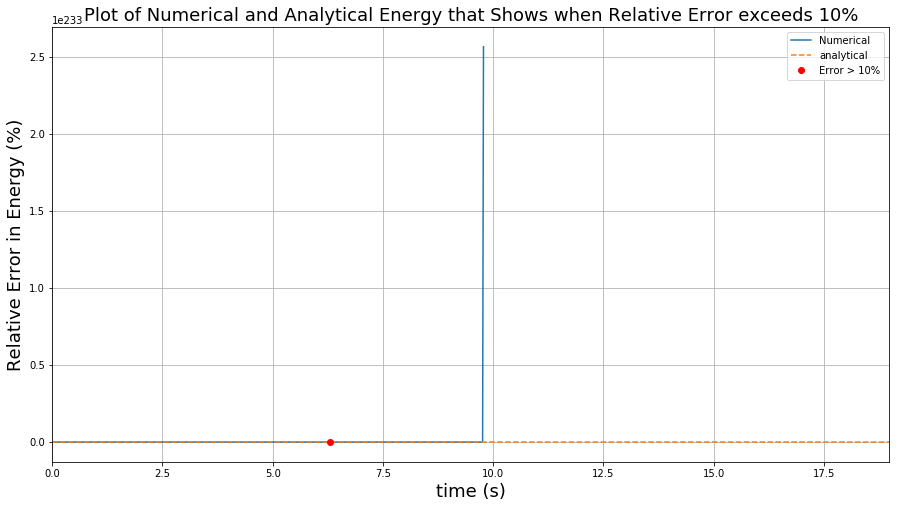

The Moment that relative error exceeds 10% is 6.3 seconds


In [16]:
relative_error = EET_4Order(x=np.arange(0.0,50,0.75),t=np.arange(0,19,0.020),time=0,c=1,save_stride=99,plot=True)
print('The Moment that relative error exceeds 10% is',relative_error,'seconds')

This result is a bit bizzare, we should be increasing the accuracy of the finite difference resulting in a longer time the numerical solution should last for. Let's look into the contour plot of the fourht order.

In [17]:
def plot_4order_contour(dx_val,dt_val):
    '''
    Like the contour plot of the second order but will use the fourth
    order finite 
    '''
    X,Y = dx_val, dt_val
    Z = np.zeros((len(X),len(Y)))
    
    #Set uup boundries and evaluate relative energy
    for ind_x, dx in enumerate(X):
        for ind_t,dt in enumerate(Y):
            x=np.arange(0,50,dx)
            t=np.arange(0,19,dt)
            
            wave = kdv_wave(x=x,t=t,c=1,a=None)
            u0 = wave.soliton(x=x,t=0,c=1,a=None)
            wave.net_energy(u=u0,t=np.arange(0,19,dt),order4=True)
            
            for rel_error in range(len(t)):
                if(np.abs(wave.energy[rel_error]-wave.energy[0]))/wave.energy[0] > 0.1:
                    Z[ind_x,ind_t] = wave.t[rel_error]
                    break
    plt.figure(figsize=(15,8))
    plt.ylabel('Resolution of Time (dt)', fontsize=18)
    plt.xlabel('Resolution of Positions (dx)', fontsize=18)
    plt.title('Time when Relative Error of dt and dx Exceeds 10%', fontsize = 18)
    plt.contourf(X,Y,np.transpose(Z),99,cmap='plasma')
    plt.grid(linestyle = '--')
    cbar=plt.colorbar()
    cbar.set_label('Time (s)', fontsize=18)
    return np.max(Z), np.unravel_index(np.argmax(Z, axis=None), Z.shape)

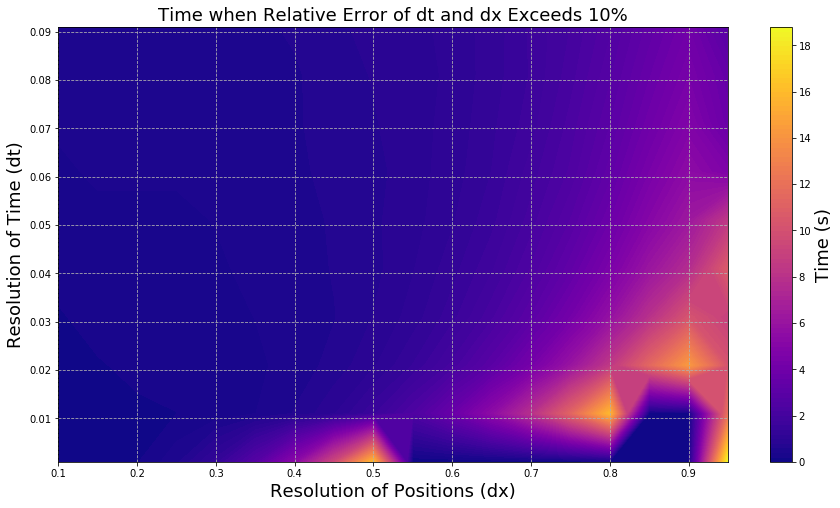

In [18]:
dx_val = np.arange(0.1,1.0,0.05)
dt_val = np.arange(0.001,0.1,0.01)
time, index = plot_4order_contour(dx_val, dt_val)
dx = dx_val[index[0]]
dt = dt_val[index[1]]


In [19]:
print('when the positional resolution is ' +str(dx)+ ' and the time resolution is '+str(dt)+ ' the will be good for ' +str(time)+' seconds.')


when the positional resolution is 0.9500000000000003 and the time resolution is 0.001 the will be good for 18.707 seconds.


From the contour plot we see that to maximize the the time dx and dt need to be 0.95 and 0.001 respectively, so now I will redo the EET plot and compare to the result from the second order to compare accuracy.

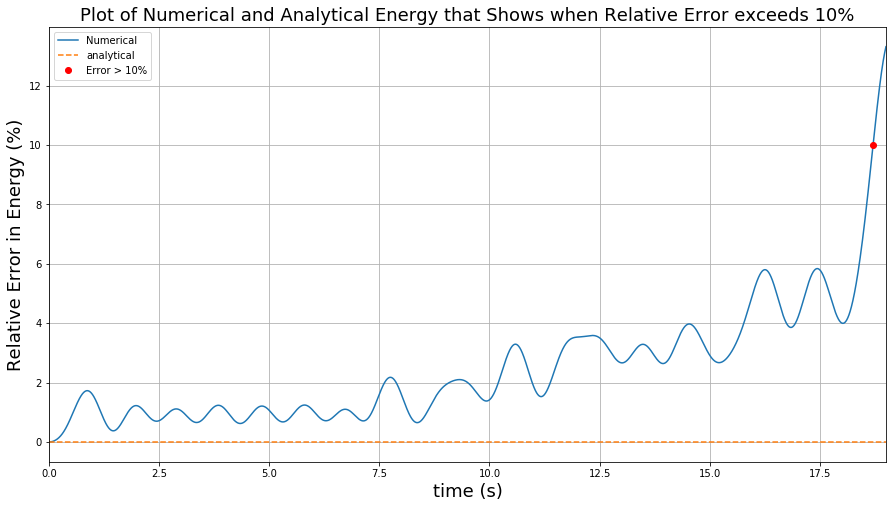

The Moment that relative error exceeds 10% is 18.707 seconds


In [20]:
fourth_relative_error = EET_4Order(x=np.arange(0.0,50,0.95),t=np.arange(0,19,0.001),time=0,c=1,save_stride=99,plot=True)
print('The Moment that relative error exceeds 10% is',fourth_relative_error,'seconds')

This plot looks more like what we expect unlike the original plot for EET of the forth order finite difference. It also supports what was hypothosized, increasing the order of the finite difference should increace the accuracy over a longer time, comparing the times that the error goes over 10% we see we gain a second of accuracy when compared to the second order finite difference. Now how does increasing the accuracy affect the computational time required.

In [21]:
%timeit updated_relative_error 
%timeit fourth_relative_error 

29.1 ns ± 2.23 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
25.4 ns ± 2.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


From these times we see that there is little difference between the computational times for the fourth order and second order. This makes sense due to the code, they both are similar and call the net_energy function from the class that consists both the second order and fourth order finite differences, the only thing that would affect the timing of them is how fast it can compute the the mathematics of each one, since they both consist of basic math functions, so we would expect little time change between them.

<center>
    
### Task 6


###### Briefly explain how you could increase the accuracy of time derivatives and discuss whether this is likely to help. 
</center>

We could probably increase the accuracy of time derivatives by performing central finite differencing, up to the fourth order as well. Although this sounds like a good idea in practice, I don't think it is likely to help with increasing the accuracy of this assessment. This is because the equation for momentum and energy are integrals with respect to x, so evaluating the central finite difference of time wouldn't affect these integrals and therefore would not effect the final results of this assessment.

<center>
    
### Conclusion 

</center>

In task 1, we were asked to modify the kdv_stepper to return energy and plot the energy. I created a class that defined the kdv wave and functions to go with it such as momentum and energy along with the second order finite difference equations and fourth order difference equations. By comparing my plots of the wave with changing c values and momentum and comparing them to the posted plots, I determined that what I had classed was correct so then I moved to plotting the energy and the relative error in energy, not much information was able to extrapolated from these plots, this lead to the ideas in the second task.

In task 2, we were asked to create a function that returned the time at which the relative error exceeded 10%. I decided to plot a curve of relative error and indicate when the error exceeded by 10% with a red dot, I did this as more information is given to use by a graph rather than a returned value. From this we obtained an understanding when the numerical solution can be used due to it's accuracy, assuming that anything over 10% isn't accurate. This plot was created using the parameters giving in task 1, were those the optimized parameters though? Task 3 investigated this.

In task 3, we were asked to create a contour plot for a range of $\Delta x$ and $\Delta t$  values and comment on this. This contour plot showed how affecting dt and dx values could cause an increase the accuracy of the numerical solution, for me I saw that the maximized accuray of the numerical solution occured at dx = 0.65 and dt = 0.011, this was different than the given parameters from task 1, this saw the results from task 2 to double in time by optimizing the parameters, thus increasing the accuracy of the numerical solution.

In task 4, we wanted to create a 4th order finite difference expression, to see if this can increase the accuracy of the numerical solution. Using the given wikipedia page, it was pretty easy to determine the fourht order finite differencial equations.

In task 5, we want to use the 4th order finite difference and see if we can increase the accuracy of the numerical solution. This was done by creating a contour plot and an EET plot like we did in task 2. Performing these similar tasks to task 2 and 3 we saw that to optimize the numerical solution dx = 0.95 and dt = 0.001, which saw the accuracy of the numerical solution last up to 18.7 seconds. This is a second and a bit longer than the second order finite difference and didn't cost any significant computing time. 

In task 6, we were asked to discuss how to increase the accuracy of the time derivatives. I explored the ideas of using central finite difference of time but noticed that due to the expressions of energy, doing this wouldn't have an effect on the results we saw in this assessment.

